# cmi_1d_ggg()

## Imports

In [1]:
import time
from itertools import product
import cupy as cp
import numpy as np
import frites
import xfrites
import scipy as sp
from cupyx.scipy.special import digamma as psi
# from mne.utils import ProgressBar
import matplotlib.pyplot as plt
%matplotlib inline

print(f"Cupy : {cp.__version__}")
print(f"Numpy : {np.__version__}")
print(f"Frites : {frites.__version__}")
print(f"Xfrites : {xfrites.__version__}")

## CPU function

In [1]:
def cpu_cmi_1d_ggg(x, y, z, biascorrect=True, demeaned=False):
    """Conditional MI between two Gaussian variables conditioned on a third.

    I = cmi_ggg(x,y,z) returns the CMI between two (possibly multidimensional)
    Gaussian variables, x and y, conditioned on a third, z, with bias
    correction.

    Parameters
    ----------
    x, y, z : array_like
        Gaussians arrays of shape (n_epochs,) or (n_dimensions, n_epochs).
    biascorrect : bool | True
        Specifies whether bias correction should be applied to the estimated MI
    demeaned : bool | False
        Specifies whether the input data already has zero mean (true if it has
        been copula-normalized)

    Returns
    -------
    i : float
        Information shared by x and y conditioned by z (in bits)
    """
    x, y, z = np.atleast_2d(x), np.atleast_2d(y), np.atleast_2d(z)
    if x.ndim > 2 or y.ndim > 2 or z.ndim > 2:
        raise ValueError("x, y and z must be at most 2d")
    ntrl = x.shape[1]
    nvarx = x.shape[0]
    nvary = y.shape[0]
    nvarz = z.shape[0]
    nvaryz = nvary + nvarz
    nvarxy = nvarx + nvary
    nvarxz = nvarx + nvarz
    nvarxyz = nvarx + nvaryz

    if y.shape[1] != ntrl or z.shape[1] != ntrl:
        raise ValueError("number of trials do not match")

    # joint variable
    xyz = np.vstack((x, y, z))
    if not demeaned:
        xyz = xyz - xyz.mean(axis=1)[:, np.newaxis]
    cxyz = np.dot(xyz, xyz.T) / float(ntrl - 1)
    # submatrices of joint covariance
    cz = cxyz[nvarxy:, nvarxy:]
    cyz = cxyz[nvarx:, nvarx:]
    cxz = np.zeros((nvarxz, nvarxz))
    cxz[:nvarx, :nvarx] = cxyz[:nvarx, :nvarx]
    cxz[:nvarx, nvarx:] = cxyz[:nvarx, nvarxy:]
    cxz[nvarx:, :nvarx] = cxyz[nvarxy:, :nvarx]
    cxz[nvarx:, nvarx:] = cxyz[nvarxy:, nvarxy:]

    chcz = np.linalg.cholesky(cz)
    chcxz = np.linalg.cholesky(cxz)
    chcyz = np.linalg.cholesky(cyz)
    chcxyz = np.linalg.cholesky(cxyz)

    # entropies in nats
    # normalizations cancel for cmi
    hz = np.sum(np.log(np.diagonal(chcz)))
    hxz = np.sum(np.log(np.diagonal(chcxz)))
    hyz = np.sum(np.log(np.diagonal(chcyz)))
    hxyz = np.sum(np.log(np.diagonal(chcxyz)))

    ln2 = np.log(2)
    if biascorrect:
        psiterms = sp.special.psi(
            (ntrl - np.arange(1, nvarxyz + 1)).astype(np.float) / 2.) / 2.
        dterm = (ln2 - np.log(ntrl - 1.)) / 2.
        hz = hz - nvarz * dterm - psiterms[:nvarz].sum()
        hxz = hxz - nvarxz * dterm - psiterms[:nvarxz].sum()
        hyz = hyz - nvaryz * dterm - psiterms[:nvaryz].sum()
        hxyz = hxyz - nvarxyz * dterm - psiterms[:nvarxyz].sum()

    # MI in bits
    i = (hxz + hyz - hxyz - hz) / ln2
    return i

## GPU function

In [1]:
def gpu_cmi_1d_ggg(x, y, z, biascorrect=True, demeaned=False):
    """Conditional MI between two Gaussian variables conditioned on a third.

    I = cmi_ggg(x,y,z) returns the CMI between two (possibly multidimensional)
    Gaussian variables, x and y, conditioned on a third, z, with bias
    correction.

    Parameters
    ----------
    x, y, z : array_like
        Gaussians arrays of shape (n_epochs,) or (n_dimensions, n_epochs).
    biascorrect : bool | True
        Specifies whether bias correction should be applied to the estimated MI
    demeaned : bool | False
        Specifies whether the input data already has zero mean (true if it has
        been copula-normalized)

    Returns
    -------
    i : float
        Information shared by x and y conditioned by z (in bits)
    """
    x, y, z = cp.atleast_2d(x), cp.atleast_2d(y), cp.atleast_2d(z)
    if x.ndim > 2 or y.ndim > 2 or z.ndim > 2:
        raise ValueError("x, y and z must be at most 2d")
    ntrl = x.shape[1]
    nvarx = x.shape[0]
    nvary = y.shape[0]
    nvarz = z.shape[0]
    nvaryz = nvary + nvarz
    nvarxy = nvarx + nvary
    nvarxz = nvarx + nvarz
    nvarxyz = nvarx + nvaryz

    if y.shape[1] != ntrl or z.shape[1] != ntrl:
        raise ValueError("number of trials do not match")

    # joint variable
    xyz = cp.vstack((x, y, z))
    if not demeaned:
        xyz = xyz - xyz.mean(axis=1)[:, cp.newaxis]
    cxyz = cp.dot(xyz, xyz.T) / float(ntrl - 1)
    # submatrices of joint covariance
    cz = cxyz[nvarxy:, nvarxy:]
    cyz = cxyz[nvarx:, nvarx:]
    cxz = cp.zeros((nvarxz, nvarxz))
    cxz[:nvarx, :nvarx] = cxyz[:nvarx, :nvarx]
    cxz[:nvarx, nvarx:] = cxyz[:nvarx, nvarxy:]
    cxz[nvarx:, :nvarx] = cxyz[nvarxy:, :nvarx]
    cxz[nvarx:, nvarx:] = cxyz[nvarxy:, nvarxy:]

    chcz = cp.linalg.cholesky(cz)
    chcxz = cp.linalg.cholesky(cxz)
    chcyz = cp.linalg.cholesky(cyz)
    chcxyz = cp.linalg.cholesky(cxyz)

    # entropies in nats
    # normalizations cancel for cmi
    hz = cp.sum(cp.log(cp.diagonal(chcz)))
    hxz = cp.sum(cp.log(cp.diagonal(chcxz)))
    hyz = cp.sum(cp.log(cp.diagonal(chcyz)))
    hxyz = cp.sum(cp.log(cp.diagonal(chcxyz)))

    ln2 = cp.log(2)
    if biascorrect:
        psiterms = psi(
            (ntrl - cp.arange(1, nvarxyz + 1)).astype(cp.float) / 2.) / 2.
        dterm = (ln2 - cp.log(ntrl - 1.)) / 2.
        hz = hz - nvarz * dterm - psiterms[:nvarz].sum()
        hxz = hxz - nvarxz * dterm - psiterms[:nvarxz].sum()
        hyz = hyz - nvaryz * dterm - psiterms[:nvaryz].sum()
        hxyz = hxyz - nvarxyz * dterm - psiterms[:nvarxyz].sum()

    # MI in bits
    i = (hxz + hyz - hxyz - hz) / ln2
    return i

## Testing

In [1]:
# n_epochs = np.arange(2000, 30001, 2000)
# nt_points = np.arange(500, 2001, 500)

n_epochs = np.arange(50000, 80001, 5000)
nt_points = np.arange(1000, 2001, 500)

pairs = product(n_epochs, nt_points)

# cpu_vals, gpu_vals = np.array([]), np.array([])
cpu_times, gpu_times = [], []
for p in pairs:
  ne = p[0]
  ntp = p[1]
  
  cx = np.random.uniform(-10, 10, (ne, ntp))
  cy = np.random.uniform(-10, 10, (ne, ntp))
  cz = np.random.uniform(-10, 10, (ne, ntp))

  gx = cp.asarray(cx)
  gy = cp.asarray(cy)
  gz = cp.asarray(cz)
  
#   pbar = ProgressBar(range(ntp), mesg="CPU implementation")
  start = time.time()
  for tp in range(ntp):
    cpu_i = cpu_cmi_1d_ggg(cx[:, tp], cy[:, tp], cz[:, tp], biascorrect=True)
#     cpu_vals = np.hstack((cpu_vals, cpu_i))
#     pbar.update_with_increment_value(1)
  stop = time.time()
  cpu_times.append(stop - start)
    
#   pbar = ProgressBar(range(ntp), mesg="GPU implementation")
  start = time.time()  
  for tp in range(ntp):
    gpu_i = gpu_cmi_1d_ggg(gx[:, tp], gy[:, tp], gz[:, tp], biascorrect=True)
#     gpu_vals = np.hstack((gpu_vals, gpu_i))
#     pbar.update_with_increment_value(1)
  stop = time.time()
  gpu_times.append(stop - start)
    
#   np.testing.assert_allclose(gpu_vals.get(), cpu_vals, rtol=1e-5)
  print(p, 'done')

## Plot results

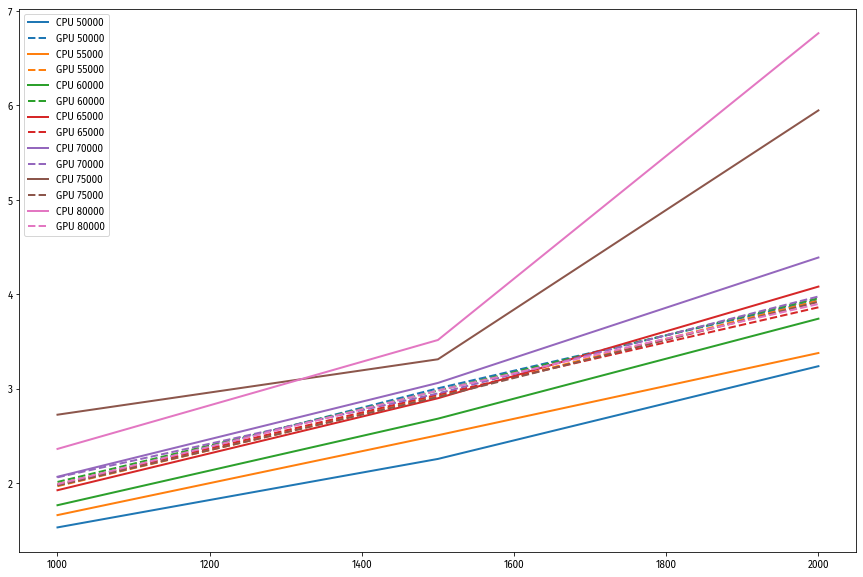

[]

In [1]:
%matplotlib inline

array_cpu_times = np.array(cpu_times).reshape(len(n_epochs), len(nt_points))
array_gpu_times = np.array(gpu_times).reshape(len(n_epochs), len(nt_points))

fig = plt.figure(figsize=(15, 10))
for i in range(len(n_epochs)):
  color = 'C{0}'.format(i)
  plt.plot(nt_points, array_cpu_times[i, :], color=color, linestyle='-', 
           linewidth=2, label='CPU {0}'.format(n_epochs[i]))
  plt.plot(nt_points, array_gpu_times[i, :], color=color, linestyle='--', 
           linewidth=2, label='GPU {0}'.format(n_epochs[i]))

plt.legend()

plt.plot()
